# Application of Random Forest Regression to Predicting Flare Durations from GOES XRS Data

This notebook generates a random forest regressor using measured features in order to predict times $t_3$ and $t_4$.  The results are shown in 2D histograms, as described in the paper.  The randomness has been currently switched off, that is, the random seed in the regressor has been set to a fixed value so that the plots may be reproduced exactly.  To use a truly random calculation, in the definition of the regressions, set random_state = `None`.  

In [1]:
from datetime import datetime

import h5py
import random 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
from matplotlib.colors import LogNorm
import seaborn as sns
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import TheilSenRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = ':'

## Read In and Visualize Training Data

The variables include ten timings, $t_{i}$, five for each GOES/XRS channel.  In this code, we label the timings $t_{i}$ in XRS-B (0.1-0.8 nm) 0 through 4, and the timings in XRS-A (0.05-0.4 nm) 5 through 9.  We include the times $t_{i}$, and at those times, the flux $F_{i}$ in each channel, the time derivative $\frac{dF}{dt}|_{i}$, and the fluence $A_{i} = \int_{0}^{i} F(t) dt$.  The subscripts $A$ and $B$ refer to the channel the quantities are measured in.

We also include the full-width-at-half-maximum (FWHM) of each channel.

In [3]:
var_names = ([f'f{i}_b' for i in range(10)] + [f't_{i}' for i in range(10)] + [f'a{i}_b' for i in range(10)] +
             [f'dfdt{i}_b' for i in range(10)] + [f'f{i}_a' for i in range(10)] +
             [f'a{i}_a' for i in range(10)] + [f'dfdt{i}_a' for i in range(10)] +
             ['ptd', 'temperature', 'em', 'start_time', 'end_time', 'fwhm_b', 'decay_b', 't_sb', 't_eb',
              'fwhm_a', 'decay_a', 't_sa', 't_ea',])
with h5py.File('goes15_recal.h5','r') as hf:
    data = {v: hf[v][:].squeeze() for v in var_names}

We first create plots showing the correlations or lack thereof between the timings measured in the whole sample of flares.  The distributions of FWHMs are log-normal and are uncorrelated with the GOES class.  Because the duration is not correlated with the GOES class, we cannot simply predict the duration based on the class.

Plot histograms of classes and FWHM for each channel

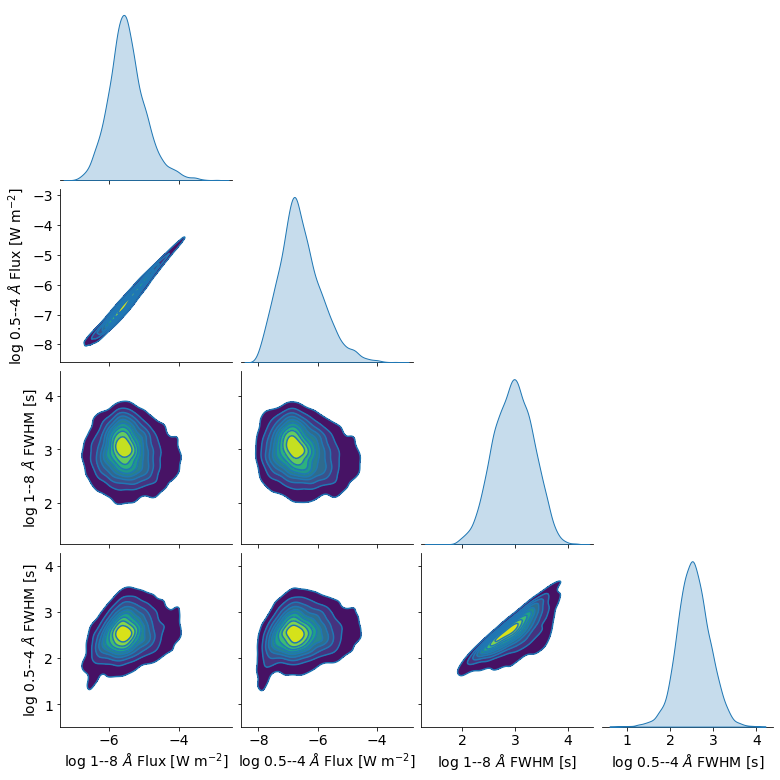

In [4]:
df = DataFrame({'log 1--8 $\AA$ Flux [W m$^{-2}$]':np.log10(data['f2_b']),
                'log 0.5--4 $\AA$ Flux [W m$^{-2}$]':np.log10(data['f7_a']),
                'log 1--8 $\AA$ FWHM [s]':np.log10(data['fwhm_b']),
                'log 0.5--4 $\AA$ FWHM [s]':np.log10(data['fwhm_a']),})

p = sns.pairplot(df, diag_kind = "kde", kind='kde', height=2.75, corner=True, )
p = p.map_lower(sns.kdeplot, cmap="viridis", shade=True, )

plt.savefig('class_duration.png', dpi=300, bbox_inches='tight',)

Then, plot histograms of the timings (in XRS-B)

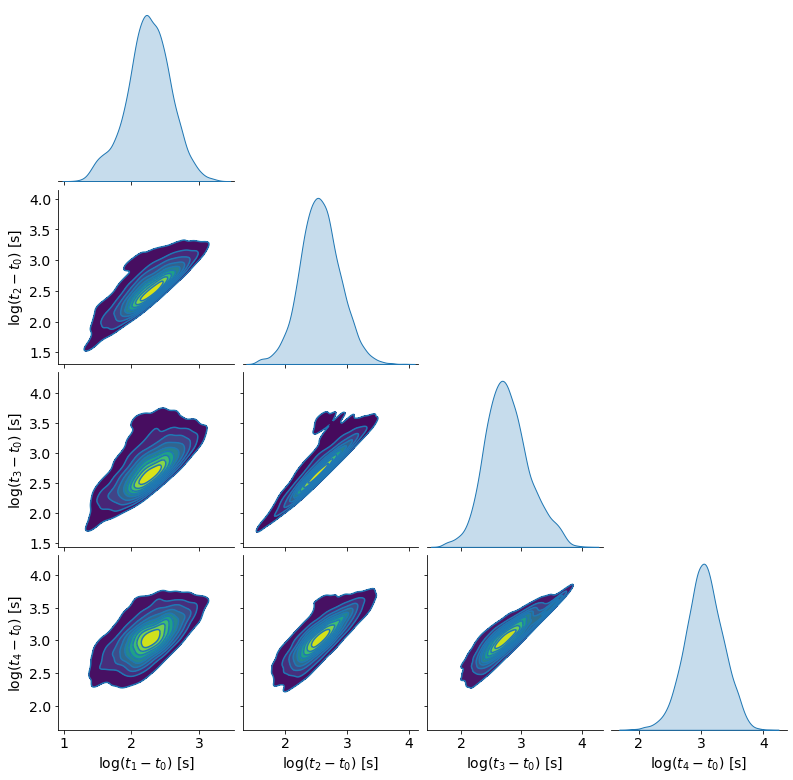

In [5]:
df = DataFrame({r'log($t_{1} - t_{0}$) [s]':np.log10(data['t_1']-data['t_0']),
                r'log($t_{2} - t_{0}$) [s]':np.log10(data['t_2']-data['t_0']),
                r'log($t_{3} - t_{0}$) [s]':np.log10(data['t_3']-data['t_0']),
                r'log($t_{4} - t_{0}$) [s]':np.log10(data['t_4']-data['t_0'])})

p = sns.pairplot(df, diag_kind = "kde", kind='kde', height=2.75, corner=True, )
p = p.map_lower(sns.kdeplot, cmap="viridis", shade=True, )

plt.savefig('ti_18.png', dpi=300, bbox_inches='tight',)

## Training a Random Forest--Features up through $t_2$

Now, we create the random forest regressors and train them on the current data.

In the first instance of this, we train using features through time $t_2$ in order to predict both $t_3$ and $t_4$, as well as the fluences at those times. (N.B. $t_{3}$ and $t_{4}$ in XRS-A are labeled 8 and 9 in this code for simplicity in differentiating them.) 

First, create a data matrix for the relevant variables and then do a test-train split.

In [6]:
ind = np.arange(len(data['start_time']))  # This is for selecting out other entries corresponding to the train/test split.
var_names3 = (
    [f'f{i}_b' for i in range(3)] + [f'f{i}_a' for i in range(3)] + [f'f{i}_b' for i in range(5,8)] +
    [f'f{i}_a' for i in range(5,8)] + [f't_{i}' for i in range(3)] + [f't_{i}' for i in range(5,8)] +
    [f'a{i}_b' for i in range(3)] + [f'a{i}_a' for i in range(3)] + [f'a{i}_b' for i in range(5,8)] +
    [f'a{i}_a' for i in range(5,8)] + [f'dfdt{i}_b' for i in range(3)] + [f'dfdt{i}_a' for i in range(3)] + 
    [f'dfdt{i}_b' for i in range(5,8)] + [f'dfdt{i}_a' for i in range(5,8)]
)

features3 = np.array([data[v] for v in var_names3]).T
labels3 = np.array([data['t_3'], data['t_4'], data['t_8'], data['t_9'], 
                    data['a3_b'], data['a4_b'], data['a8_a'], data['a9_a']]).T

In [7]:
# change random_state = None for truly random splits.
train_features, test_features, train_labels, test_labels, train_ind, test_ind = train_test_split(
    features3, labels3, ind, test_size = 0.33, random_state = 25)

Finally create and train the random forest.

In [8]:
rf_options = {
    'n_estimators': 1500,
    'max_features': 'auto',
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'max_depth': 10,
    'n_jobs': -1,
}

In [9]:
rf = RandomForestRegressor(**rf_options)

In [10]:
rf.fit(train_features, train_labels)

RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=1500,
                      n_jobs=-1)

Use the trained forest to predict $t_3$ and $t_4$ from our test data.

In [11]:
predictions = rf.predict(test_features)

And then compute the test error on the predicted times

In [12]:
test_error3 = 1 - rf.score(test_features, test_labels)

In [13]:
print(test_error3)

0.5185962151912045


## Detailed Comparisons with Measured Values

Now, plot the predicted values of $t_3$ and $t_4$ against the measured values. If the random forest works perfectly, the slope should be 1 with little scatter.  We see that the slopes are less than 1 here, indicating that the random forest generally underpredicts the total duration of the events.

In [14]:
# Create a linear regressor.  Set random_state=None for truly random groupings.
estimator = TheilSenRegressor(random_state=10, n_jobs=-1, max_subpopulation=3e4)

First, plot the predictions of $t_{3}$ in XRS-B.

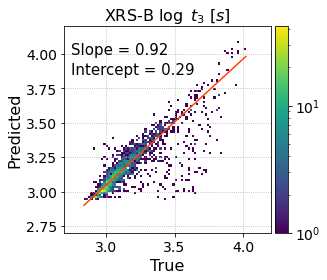

In [15]:
# Fit a line to the data
x_plot = np.linspace(np.log10(test_labels[:,0].min()), np.log10(test_labels[:,0].max()))
estimator.fit(np.log10(test_labels[:,[0]]), np.log10(predictions[:,[0]]))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

# Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels[:,0]), np.log10(predictions[:,0]), bins=75, norm=LogNorm())

plt.plot(x_plot, y_plot, color='orangered')
plt.text(2.75, 4.0, 'Slope = %.2f' %(slope18), fontsize=15)
plt.text(2.75, 3.85, 'Intercept = %.2f' %(int18), fontsize=15)
plt.xlabel(r'True', fontsize=16)
plt.ylabel(r'Predicted', fontsize=16)
plt.title(r'XRS-B $\log\ t_{3}\ [s]$')
plt.xlim(2.7, 4.2)
plt.ylim(2.7, 4.2)
plt.tight_layout()
plt.grid(True, which='major', axis='both')

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)

plt.savefig('t3_18.png', dpi=300, bbox_inches='tight',)

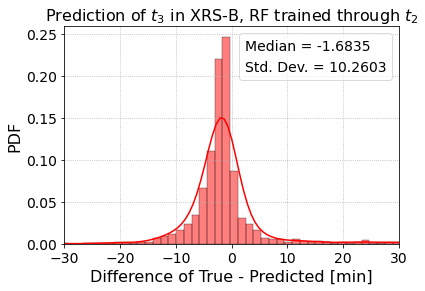

In [16]:
# Plot the distribution of errors

diff_t3B = (test_labels[:,0] - predictions[:,0]) / 60.0
sns.histplot(diff_t3B, stat="probability", bins=100, kde=True, color='red')

## Add textbox with median and standard deviation:
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 2
labels = []
labels.append("Median = {0:.4f}".format(np.median(diff_t3B)))
labels.append("Std. Dev. = {0:.4f}".format(np.std(diff_t3B)))
plt.legend(handles, labels, loc='best', fontsize=14, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
plt.ylabel(r'PDF', fontsize=16)
plt.xlim(-30,30)
plt.xlabel(r'Difference of True - Predicted [min]', fontsize=16)
plt.title(r'Prediction of $t_{3}$ in XRS-B, RF trained through $t_{2}$')
plt.grid(True, which='major', axis='both')
plt.show()


Now, plot the predictions of the fluence $A_{3} = \int_{t_{0}}^{t_{3}} F(t) dt$ in XRS-B.

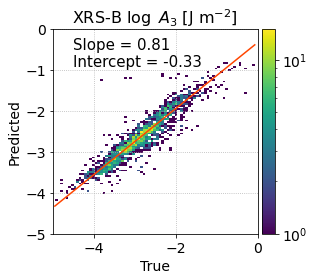

In [17]:
# Fit a line to the data
x_plot = np.linspace(np.log10(test_labels[:,4].min()), np.log10(test_labels[:,4].max()))
estimator.fit(np.log10(test_labels[:,[4]]), np.log10(predictions[:,[4]]))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

# Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels[:,4]), np.log10(predictions[:,4]), bins=75, norm=LogNorm())

plt.plot(x_plot, y_plot, color='orangered')
plt.text(-4.5,-0.5,'Slope = %.2f' %(slope18),fontsize=15)
plt.text(-4.5,-0.9,'Intercept = %.2f' %(int18),fontsize=15)
plt.xlabel(r'True',)
plt.ylabel(r'Predicted',)
plt.title(r'XRS-B $\log\ A_{3}\ $[J m$^{-2}$]',)
plt.xlim(-5,0)
plt.ylim(-5,0)
plt.tight_layout()
plt.grid(True, which='major', axis='both')

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)

plt.savefig('A3_18.png', dpi=300, bbox_inches='tight',)

Now, we repeat this for $t_{4}$ in XRS-B.

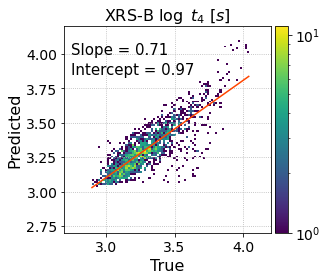

In [18]:
# Fit a line to the data
x_plot = np.linspace(np.log10(test_labels[:,1].min()), np.log10(test_labels[:,1].max()))
estimator.fit(np.log10(test_labels[:,1].reshape(-1,1)), np.log10(predictions[:,1].reshape(-1,1)))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

# Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels[:,1]), np.log10(predictions[:,1]), bins=75, norm=LogNorm())
plt.plot(x_plot, y_plot, color='orangered')
plt.text(2.75, 4.0, 'Slope = %.2f' %(slope18), fontsize=15)
plt.text(2.75, 3.85, 'Intercept = %.2f' %(int18), fontsize=15)
plt.xlabel(r'True', fontsize=16)
plt.ylabel(r'Predicted', fontsize=16)
plt.title(r'XRS-B $\log\ t_{4}\ [s]$',)
plt.xlim(2.7, 4.2)
plt.ylim(2.7, 4.2)
plt.tight_layout()
plt.grid(True, which='major', axis='both',)

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)

plt.savefig('t4_18.png', dpi=300, bbox_inches='tight',)

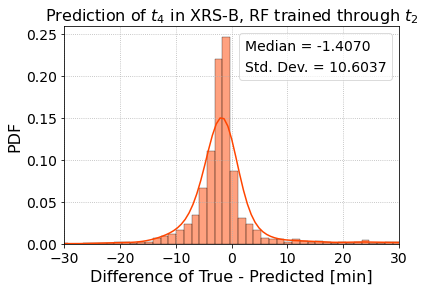

In [19]:
# Plot the distribution of errors

diff_t4B = (test_labels[:,1] - predictions[:,1]) / 60.0
sns.histplot(diff_t3B, stat="probability", bins=100, kde=True, color='orangered')

## Add textbox with median and standard deviation:
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 2
labels = []
labels.append("Median = {0:.4f}".format(np.median(diff_t4B)))
labels.append("Std. Dev. = {0:.4f}".format(np.std(diff_t4B)))
plt.legend(handles, labels, loc='best', fontsize=14, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
plt.ylabel(r'PDF', fontsize=16)
plt.xlim(-30,30)
plt.xlabel(r'Difference of True - Predicted [min]', fontsize=16)
plt.title(r'Prediction of $t_{4}$ in XRS-B, RF trained through $t_{2}$')
plt.grid(True, which='major', axis='both')

plt.savefig('t4_18_error.png', dpi=300, bbox_inches='tight',)

And the fluence $A_{4} = \int_{t_{0}}^{t_{4}} F(t) dt$ in XRS-B.

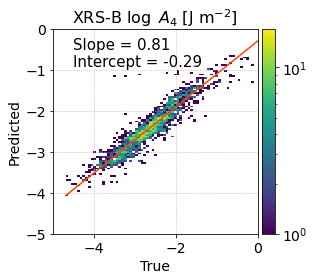

In [20]:
# Fit a line to the data
x_plot = np.linspace(np.log10(test_labels[:,5].min()), np.log10(test_labels[:,5].max()))
estimator.fit(np.log10(test_labels[:,[5]]), np.log10(predictions[:,[5]]))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

# Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels[:,5]), np.log10(predictions[:,5]), bins=75, norm=LogNorm())

plt.plot(x_plot, y_plot, color='orangered')
plt.text(-4.5,-0.5,'Slope = %.2f' %(slope18),fontsize=15)
plt.text(-4.5,-0.9,'Intercept = %.2f' %(int18),fontsize=15)
plt.xlabel(r'True',)
plt.ylabel(r'Predicted',)
plt.title(r'XRS-B $\log\ A_{4}\ $[J m$^{-2}$]',)
plt.xlim(-5,0)
plt.ylim(-5,0)
plt.tight_layout()
plt.grid(True, which='major', axis='both')

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)

plt.savefig('A4_18.png', dpi=300, bbox_inches='tight',)

Finally, we repeat all of the above for XRS-A.

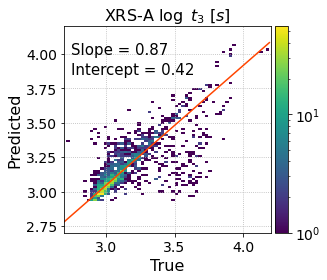

In [21]:
# Fit a line to the data
x_plot = np.linspace(np.log10(test_labels[:,2].min()), np.log10(test_labels[:,2].max()))
estimator.fit(np.log10(test_labels[:,2].reshape(-1,1)), np.log10(predictions[:,2].reshape(-1,1)))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

# Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels[:,2]), np.log10(predictions[:,2]), bins=75, norm=LogNorm())
plt.plot(x_plot, y_plot, color='orangered')
plt.text(2.75, 4.0, 'Slope = %.2f' %(slope18), fontsize=15)
plt.text(2.75, 3.85, 'Intercept = %.2f' %(int18), fontsize=15)
plt.xlabel(r'True', fontsize=16)
plt.ylabel(r'Predicted', fontsize=16)
plt.title(r'XRS-A $\log\ t_{3}\ [s]$',)
plt.xlim(2.7, 4.2)
plt.ylim(2.7, 4.2)
plt.tight_layout()
plt.grid(True, which='major', axis='both',)

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)

plt.savefig('t3_054.png', dpi=300, bbox_inches='tight',)

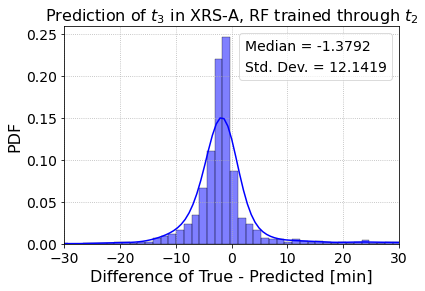

In [22]:
# Plot the distribution of errors

diff_t3A = (test_labels[:,2] - predictions[:,2]) / 60.0
sns.histplot(diff_t3B, stat="probability", bins=100, kde=True, color='blue')

## Add textbox with median and standard deviation:
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 2
labels = []
labels.append("Median = {0:.4f}".format(np.median(diff_t3A)))
labels.append("Std. Dev. = {0:.4f}".format(np.std(diff_t3A)))
plt.legend(handles, labels, loc='best', fontsize=14, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
plt.ylabel(r'PDF', fontsize=16)
plt.xlim(-30,30)
plt.xlabel(r'Difference of True - Predicted [min]', fontsize=16)
plt.title(r'Prediction of $t_{3}$ in XRS-A, RF trained through $t_{2}$')
plt.grid(True, which='major', axis='both')
plt.show()


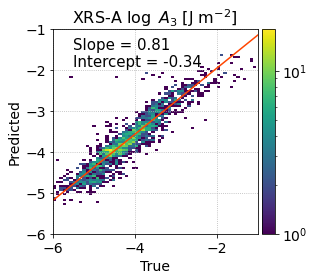

In [23]:
# Fit a line to the data
x_plot = np.linspace(np.log10(test_labels[:,6].min()), np.log10(test_labels[:,6].max()))
estimator.fit(np.log10(test_labels[:,[6]]), np.log10(predictions[:,[6]]))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

# Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels[:,6]), np.log10(predictions[:,6]), bins=75, norm=LogNorm())

plt.plot(x_plot, y_plot, color='orangered')
plt.text(-5.5,-1.5,'Slope = %.2f' %(slope18),fontsize=15)
plt.text(-5.5,-1.9,'Intercept = %.2f' %(int18),fontsize=15)
plt.xlabel(r'True',)
plt.ylabel(r'Predicted',)
plt.title(r'XRS-A $\log\ A_{3}\ $[J m$^{-2}$]',)
plt.xlim(-6,-1)
plt.ylim(-6,-1)
plt.tight_layout()
plt.grid(True, which='major', axis='both')

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)

plt.savefig('A3_054.png', dpi=300, bbox_inches='tight',)

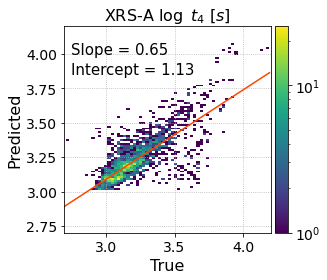

In [24]:
# Fit a line to the data
x_plot = np.linspace(np.log10(test_labels[:,3].min()), np.log10(test_labels[:,3].max()))
estimator.fit(np.log10(test_labels[:,3].reshape(-1,1)), np.log10(predictions[:,3].reshape(-1,1)))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

# Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels[:,3]), np.log10(predictions[:,3]), bins=75, norm=LogNorm())
plt.plot(x_plot, y_plot, color='orangered')
plt.text(2.75, 4.0, 'Slope = %.2f' %(slope18), fontsize=15)
plt.text(2.75, 3.85, 'Intercept = %.2f' %(int18), fontsize=15)
plt.xlabel(r'True', fontsize=16)
plt.ylabel(r'Predicted', fontsize=16)
plt.title(r'XRS-A $\log\ t_{4}\ [s]$',)
plt.xlim(2.7, 4.2)
plt.ylim(2.7, 4.2)
plt.tight_layout()
plt.grid(True, which='major', axis='both',)

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)

plt.savefig('t4_054.png', dpi=300, bbox_inches='tight',)

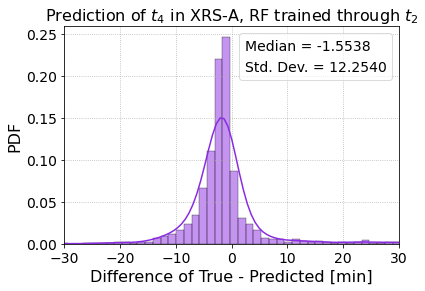

In [25]:
# Plot the distribution of errors

diff_t4A = (test_labels[:,3] - predictions[:,3]) / 60.0
sns.histplot(diff_t3B, stat="probability", bins=100, kde=True, color='blueviolet')

## Add textbox with median and standard deviation:
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 2
labels = []
labels.append("Median = {0:.4f}".format(np.median(diff_t4A)))
labels.append("Std. Dev. = {0:.4f}".format(np.std(diff_t4A)))
plt.legend(handles, labels, loc='best', fontsize=14, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
plt.ylabel(r'PDF', fontsize=16)
plt.xlim(-30,30)
plt.xlabel(r'Difference of True - Predicted [min]', fontsize=16)
plt.title(r'Prediction of $t_{4}$ in XRS-A, RF trained through $t_{2}$')
plt.grid(True, which='major', axis='both')

plt.savefig('t4_054_error.png', dpi=300, bbox_inches='tight',)

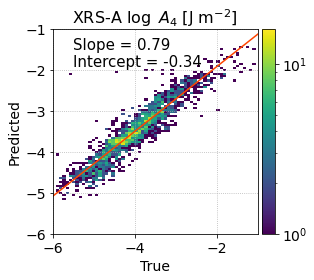

In [26]:
# Fit a line to the data
x_plot = np.linspace(np.log10(test_labels[:,7].min()), np.log10(test_labels[:,7].max()))
estimator.fit(np.log10(test_labels[:,[7]]), np.log10(predictions[:,[7]]))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

# Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels[:,7]), np.log10(predictions[:,7]), bins=75, norm=LogNorm())

plt.plot(x_plot, y_plot, color='orangered')
plt.text(-5.5,-1.5,'Slope = %.2f' %(slope18),fontsize=15)
plt.text(-5.5,-1.9,'Intercept = %.2f' %(int18),fontsize=15)
plt.xlabel(r'True',)
plt.ylabel(r'Predicted',)
plt.title(r'XRS-A $\log\ A_{4}\ $[J m$^{-2}$]',)
plt.xlim(-6,-1)
plt.ylim(-6,-1)
plt.tight_layout()
plt.grid(True, which='major', axis='both')

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)

plt.savefig('A4_054.png', dpi=300, bbox_inches='tight',)

## Training a Random Forest--Features up through $t_3$

Next, we repeat this calculation, except that we use the values through time t3 to predict t4.

In [27]:
var_names4 = (
    [f'f{i}_b' for i in range(4)] + [f'f{i}_a' for i in range(4)] + [f'f{i}_b' for i in range(5,9)] +
    [f'f{i}_a' for i in range(5,9)] + [f't_{i}' for i in range(4)] + [f't_{i}' for i in range(5,9)] +
    [f'a{i}_b' for i in range(4)] + [f'a{i}_a' for i in range(4)] + [f'a{i}_b' for i in range(5,9)] +
    [f'a{i}_a' for i in range(5,9)] + [f'dfdt{i}_b' for i in range(4)] + [f'dfdt{i}_a' for i in range(4)] + 
    [f'dfdt{i}_b' for i in range(5,9)] + [f'dfdt{i}_a' for i in range(5,9)]
)

features4 = np.array([data[v] for v in var_names4]).T
labels4 = np.array([data['t_4'], data['t_9'], data['a4_b'], data['a9_a']]).T

In [28]:
train_features4, test_features4, train_labels4, test_labels4, train_ind4, test_ind4= train_test_split(
    features4, labels4, ind, test_size = 0.33, random_state = 25)

In [29]:
rf4 = RandomForestRegressor(**rf_options)

In [30]:
rf4.fit(train_features4, train_labels4);

In [31]:
predictions4 = rf4.predict(test_features4)

In [32]:
print(1 - rf4.score(test_features4, test_labels4))

0.35723638450051054


Unsurprisingly, the error here is significantly lower when we add $t_3$ to our training data.

Similarly, plot the true vs predicted values of $t_4$ in each GOES/XRS channel.  In this case, we find that the slopes are much closer to 1, indicating that the prediction is much improved, although it still slightly underestimates duration in general.

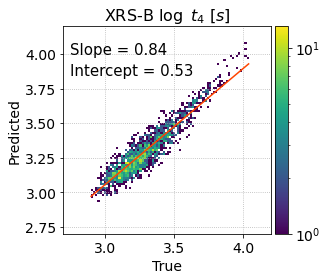

In [33]:
# Fit a line to the data
x_plot = np.linspace(np.log10(test_labels4[:,0].min()), np.log10(test_labels4[:,0].max()))
estimator.fit(np.log10(test_labels4[:,0].reshape(-1,1)),np.log10(predictions4[:,0].reshape(-1,1)))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

# Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels4[:,0]),np.log10(predictions4[:,0]),bins=75,norm=LogNorm())
plt.plot(x_plot,y_plot,color='orangered')
plt.text(2.75,4.0,'Slope = %.2f' %(slope18),fontsize=15)
plt.text(2.75,3.85,'Intercept = %.2f' %(int18),fontsize=15)
plt.xlabel(r'True',)
plt.ylabel(r'Predicted',)
plt.title(r'XRS-B $\log\ t_{4}\ [s]$',)
plt.xlim(2.7,4.2)
plt.ylim(2.7,4.2)
plt.tight_layout()
plt.grid(True,which='major',axis='both',linestyle=':')

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)

plt.savefig('second_t4_18.png', dpi=300, bbox_inches='tight',)

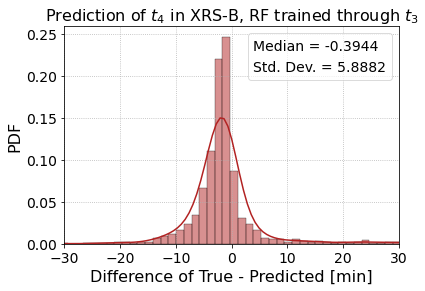

In [34]:
# Plot the error in the predictions of t_4

diff_t4B = (test_labels4[:,0] - predictions4[:,0]) / 60.0
sns.histplot(diff_t3B, stat="probability", bins=100, kde=True, color='firebrick')

## Add textbox with median and standard deviation:
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 2
labels = []
labels.append("Median = {0:.4f}".format(np.median(diff_t4B)))
labels.append("Std. Dev. = {0:.4f}".format(np.std(diff_t4B)))
plt.legend(handles, labels, loc='best', fontsize=14, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
plt.ylabel(r'PDF', fontsize=16)
plt.xlim(-30,30)
plt.xlabel(r'Difference of True - Predicted [min]', fontsize=16)
plt.title(r'Prediction of $t_{4}$ in XRS-B, RF trained through $t_{3}$')
plt.grid(True, which='major', axis='both')

plt.savefig('second_t4_18_error.png', dpi=300, bbox_inches='tight',)


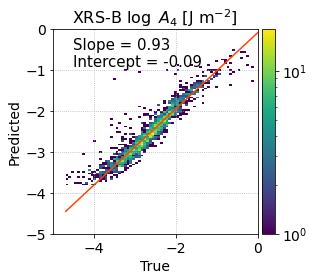

In [35]:
# Now do the fluence prediction.

# Fit a line to the data
x_plot = np.linspace(np.log10(test_labels4[:,2].min()), np.log10(test_labels4[:,2].max()))
estimator.fit(np.log10(test_labels4[:,[2]]), np.log10(predictions4[:,[2]]))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

# Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels4[:,2]), np.log10(predictions4[:,2]), bins=75, norm=LogNorm())

plt.plot(x_plot, y_plot, color='orangered')
plt.text(-4.5,-0.5,'Slope = %.2f' %(slope18),fontsize=15)
plt.text(-4.5,-0.9,'Intercept = %.2f' %(int18),fontsize=15)
plt.xlabel(r'True',)
plt.ylabel(r'Predicted',)
plt.title(r'XRS-B $\log\ A_{4}\ $[J m$^{-2}$]',)
plt.xlim(-5,0)
plt.ylim(-5,0)
plt.tight_layout()
plt.grid(True, which='major', axis='both')

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)

plt.savefig('second_A4_18.png', dpi=300, bbox_inches='tight',)

And, repeat for XRS-A:

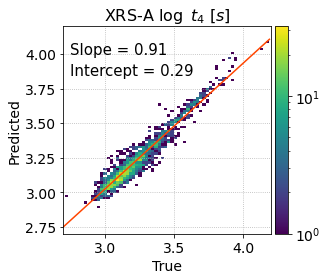

In [36]:
#Fit a line to the data
x_plot = np.linspace(np.log10(test_labels4[:,1].min()), np.log10(test_labels4[:,1].max()))
estimator.fit(np.log10(test_labels4[:,1].reshape(-1,1)),np.log10(predictions4[:,1].reshape(-1,1)))
slope054 = estimator.coef_[0]
int054 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

#Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels4[:,1]),np.log10(predictions4[:,1]),bins=75,norm=LogNorm())
plt.plot(x_plot,y_plot,color='orangered')
plt.text(2.75,4.0,'Slope = %.2f' %(slope054),fontsize=15)
plt.text(2.75,3.85,'Intercept = %.2f' %(int054),fontsize=15)
plt.xlabel(r'True',)
plt.ylabel(r'Predicted')
plt.title(r'XRS-A $\log\ t_{4}\ [s]$')
plt.xlim(2.7,4.2)
plt.ylim(2.7,4.2)
plt.tight_layout()
plt.grid(True,which='major',axis='both',)

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)

plt.savefig('second_t4_054.png', dpi=300, bbox_inches='tight',)

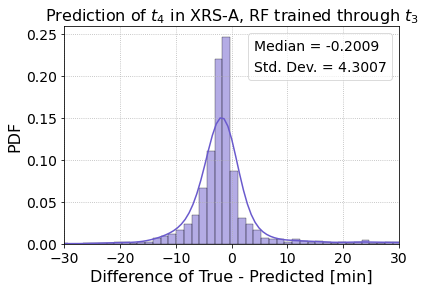

In [37]:
diff_t4A = (test_labels4[:,1] - predictions4[:,1]) / 60.0
sns.histplot(diff_t3B, stat="probability", bins=100, kde=True, color='slateblue')

## Add textbox with median and standard deviation:
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 2
labels = []
labels.append("Median = {0:.4f}".format(np.median(diff_t4A)))
labels.append("Std. Dev. = {0:.4f}".format(np.std(diff_t4A)))
plt.legend(handles, labels, loc='best', fontsize=14, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
plt.ylabel(r'PDF', fontsize=16)
plt.xlim(-30,30)
plt.xlabel(r'Difference of True - Predicted [min]', fontsize=16)
plt.title(r'Prediction of $t_{4}$ in XRS-A, RF trained through $t_{3}$')
plt.grid(True, which='major', axis='both')

plt.savefig('second_t4_054_error.png', dpi=300, bbox_inches='tight',)


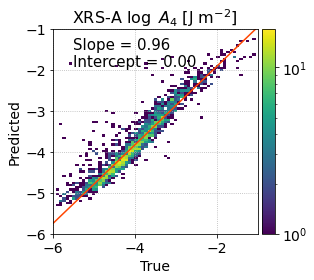

In [38]:
# Now do the fluence prediction.

# Fit a line to the data
x_plot = np.linspace(np.log10(test_labels4[:,3].min()), np.log10(test_labels4[:,3].max()))
estimator.fit(np.log10(test_labels4[:,[3]]), np.log10(predictions4[:,[3]]))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

# Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels4[:,3]), np.log10(predictions4[:,3]), bins=75, norm=LogNorm())

plt.plot(x_plot, y_plot, color='orangered')
plt.text(-5.5,-1.5,'Slope = %.2f' %(slope18),fontsize=15)
plt.text(-5.5,-1.9,'Intercept = %.2f' %(int18),fontsize=15)
plt.xlabel(r'True',)
plt.ylabel(r'Predicted',)
plt.title(r'XRS-A $\log\ A_{4}\ $[J m$^{-2}$]',)
plt.xlim(-6,-1)
plt.ylim(-6,-1)
plt.tight_layout()
plt.grid(True, which='major', axis='both')

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)

plt.savefig('second_A4_054.png', dpi=300, bbox_inches='tight',)

## Predicting $t_4$ via Linear Regression

Calculate the regression using a linear fit to predict $t_4$. That is, we assume $t_4 \sim t_2$, fit a line, and then calculate a prediction for $t_4$ using $t_2$ alone.  This prediction will then be used to estimate a skill score for the random forest against this simple model.

**Note:** we fit $(t_4-t_0)$ vs $(t_2-t_0)$ because $t_0$ is not set to zero in the data set.

First in the 1-8 Å channel

In [39]:
t2_mod = data['t_2'] - data['t_0']
t4_mod = data['t_4'] - data['t_0']
x_plot = np.linspace(np.log10(t2_mod[train_ind[:]].min()), np.log10(t2_mod[train_ind[:]].max()))
estimator.fit(np.log10(t2_mod[train_ind[:]].reshape(-1,1)),np.log10(t4_mod[train_ind[:]].reshape(-1,1)))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

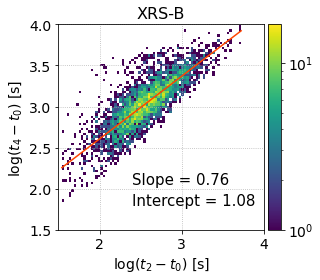

In [40]:
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(t2_mod[train_ind[:]]),np.log10(t4_mod[train_ind[:]]),bins=75,norm=LogNorm())
plt.plot(x_plot,y_plot,color='orangered')
plt.text(2.4,2.05,'Slope = %.2f' %(slope18),fontsize=15)
plt.text(2.4,1.8,'Intercept = %.2f' %(int18),fontsize=15)
plt.xlabel(r'$\log(t_{2} - t_{0})$ [s]',)
plt.ylabel(r'$\log(t_{4} - t_{0})$ [s]',)
plt.xlim(1.5,4.0)
plt.ylim(1.5,4.0)
plt.title(r'XRS-B',)
plt.grid(True,which='major',axis='both',)
plt.tight_layout()

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)

plt.savefig('t2_t4_18.png', dpi=300, bbox_inches='tight',)

And then in the 0.5-4 Å channel

In [41]:
t7_mod = data['t_7'] - data['t_5']
t9_mod = data['t_9'] - data['t_5']
x_plot = np.linspace(np.log10(t7_mod[train_ind4[:]].min()), np.log10(t7_mod[train_ind4[:]].max()))
estimator.fit(np.log10(t7_mod[train_ind4[:]].reshape(-1,1)),np.log10(t9_mod[train_ind4[:]].reshape(-1,1)))
y_plot = estimator.coef_ * x_plot + estimator.intercept_
slope054 = estimator.coef_[0]
int054 = estimator.intercept_

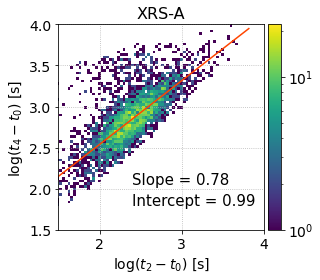

In [42]:
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(t7_mod[train_ind4[:]]),np.log10(t9_mod[train_ind4[:]]),bins=75,norm=LogNorm())
plt.plot(x_plot,y_plot,color='orangered')
plt.text(2.4,2.05,'Slope = %.2f' %(slope054),fontsize=15)
plt.text(2.4,1.8,'Intercept = %.2f' %(int054),fontsize=15)
plt.xlabel(r'$\log(t_{2} - t_{0})$ [s]',)
plt.ylabel(r'$\log(t_{4} - t_{0})$ [s]',)
plt.xlim(1.5,4.0)
plt.ylim(1.5,4.0)
plt.title(r'XRS-A',)
plt.grid(True,which='major',axis='both',)
plt.tight_layout()

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)

plt.savefig('t2_t4_054.png', dpi=300, bbox_inches='tight',)

## Comparing the Random Forest and Linear Regression Predictions

How do these predictions from the random forest fare?  We compute a skill score to check the forecast now, using the simple linear regression as the reference model. 

For each channel, we calculate the mean-squared error of the predicted vs true $t_4$ values, both from the random forest and the linear regression.  The skill score is then defined as,

$$
\mathrm{SS} = 1 - \frac{\mathrm{MSE}_{rf}}{\mathrm{MSE}_{linear}}.
$$

A skill score of 1 is a perfect prediction, between 0 and 1 the random forest outperforms the linear regression, 0 that each model performs equally well, and a negative value means that the linear regression outperforms the random forest.

We finally calculate the skill score for both cases, where we have trained the data     

(1) through time $t_2$

In [43]:
print("Case 1: RF trained with values through time t2.")
mse18 = np.mean((test_labels[:,1]-predictions[:,1])**2.)
ref_t4 = 10.0**(int18) * (t2_mod[test_ind[:]])**(slope18) + data['t_0'][test_ind[:]]
ref18 = np.mean((data['t_4'][test_ind[:]]-ref_t4[:])**2.)
print(f"Skill score in the 1--8 Angstrom channel: {1 - mse18/ref18}")
mse054 = np.mean((test_labels[:,3]-predictions[:,3])**2.)
ref_t9 = 10.0**(int054) * (t7_mod[test_ind[:]])**(slope054) + data['t_5'][test_ind[:]]
ref054 = np.mean((data['t_9'][test_ind[:]]-ref_t9[:])**2.)
print("Skill score in the 0.5--4 Angstrom channel:", 1 - mse054/ref054)


Case 1: RF trained with values through time t2.
Skill score in the 1--8 Angstrom channel: 0.015135694215431594
Skill score in the 0.5--4 Angstrom channel: 0.08480584372106892


and (2) through time $t_3$.

In [44]:
print("Case 2: RF trained with values through time t3.")
mse18 = np.mean((test_labels4[:,0]-predictions4[:,0])**2.)
ref_t4 = 10.0**(int18) * (t2_mod[test_ind4[:]])**(slope18) + data['t_0'][test_ind4[:]]
ref18 = np.mean((data['t_4'][test_ind4[:]]-ref_t4[:])**2.)
print("Skill score in the 1--8 Angstrom channel:", 1 - mse18/ref18)
mse054 = np.mean((test_labels4[:,1]-predictions4[:,1])**2.)
ref_t9 = 10.0**(int054) * (t7_mod[test_ind4[:]])**(slope054) + data['t_5'][test_ind4[:]]
ref054 = np.mean((data['t_9'][test_ind4[:]]-ref_t9[:])**2.)
print("Skill score in the 0.5--4 Angstrom channel:", 1 - mse054/ref054)

Case 2: RF trained with values through time t3.
Skill score in the 1--8 Angstrom channel: 0.6963296114850521
Skill score in the 0.5--4 Angstrom channel: 0.8872791049533112


As we can see from the skill scores, the random forest slightly outperforms linear regression when trained through time $t_2$, and significantly outperforms linear regression when trained through time $t_3$.

This is generally the case, but if the random seed used in the random forest regressor changes, these values do vary slightly and there are times when the linear regression is better in Case 1, but the random forest is always better in Case 2.

Since these only represent one case, with one train-test split, it does not give a full picture of the true skill of the random forest.  To get a better sense of this, we now run a Monte Carlo simulation where we redo the train-test split, randomizing the splits at each iteration and calculating new skill scores.  This takes a while to run, but we can get a better sense of the skill scores and how it performs compared to linear regression more generally.

First, a Monte Carlo simulation where we train the data through time $t_{2}$.  We randomize the split at each iteration, as well as the fractional size of the test group between 25 and 40\%.

In [45]:
ind = np.arange(len(data['start_time']))  # This is for selecting out other entries corresponding to the train/test split.

var_names3 = (
    [f'f{i}_b' for i in range(3)] + [f'f{i}_a' for i in range(3)] + [f'f{i}_b' for i in range(5,8)] +
    [f'f{i}_a' for i in range(5,8)] + [f't_{i}' for i in range(3)] + [f't_{i}' for i in range(5,8)] +
    [f'a{i}_b' for i in range(3)] + [f'a{i}_a' for i in range(3)] + [f'a{i}_b' for i in range(5,8)] +
    [f'a{i}_a' for i in range(5,8)] + [f'dfdt{i}_b' for i in range(3)] + [f'dfdt{i}_a' for i in range(3)] + 
    [f'dfdt{i}_b' for i in range(5,8)] + [f'dfdt{i}_a' for i in range(5,8)]
)

features3 = np.array([data[v] for v in var_names3]).T
labels3 = np.array([data['t_3'], data['t_4'], data['t_8'], data['t_9']]).T

t2_mod = data['t_2'] - data['t_0']
t4_mod = data['t_4'] - data['t_0']
t7_mod = data['t_7'] - data['t_5']
t9_mod = data['t_9'] - data['t_5']

ss18 = []
ss054 = []
rf = RandomForestRegressor(**rf_options)
for i in range(100):
    # Calculate a new train-test split and train the RF with it:
    train_features, test_features, train_labels, test_labels, train_ind, test_ind = train_test_split(
    features3, labels3, ind, test_size = 0.33, random_state = None)
    
    rf.fit(train_features, train_labels)
    predictions = rf.predict(test_features)
    
    # Fit the linear regression to the new training group:
    estimator.fit(np.log10(t2_mod[train_ind[:]].reshape(-1,1)),np.log10(t4_mod[train_ind[:]].reshape(-1,1)))
    slope18 = estimator.coef_[0]
    int18 = estimator.intercept_
    estimator.fit(np.log10(t7_mod[train_ind[:]].reshape(-1,1)),np.log10(t9_mod[train_ind[:]].reshape(-1,1)))
    slope054 = estimator.coef_[0]
    int054 = estimator.intercept_
    
    # Calculate the skill scores in each XRS channel and store them:
    mse18 = np.mean((test_labels[:,1]-predictions[:,1])**2.)
    ref_t4 = 10.0**(int18) * (t2_mod[test_ind[:]])**(slope18) + data['t_0'][test_ind[:]]
    ref18 = np.mean((data['t_4'][test_ind[:]]-ref_t4[:])**2.)
    ss18.append(1.0 - mse18/ref18)
    
    mse054 = np.mean((test_labels[:,3]-predictions[:,3])**2.)
    ref_t9 = 10.0**(int054) * (t7_mod[test_ind[:]])**(slope054) + data['t_5'][test_ind[:]]
    ref054 = np.mean((data['t_9'][test_ind[:]]-ref_t9[:])**2.)
    ss054.append(1 - mse054/ref054)


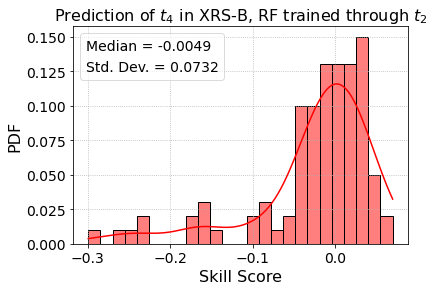

In [46]:
# Plot the PDF in XRS-B

sns.histplot(ss18, stat="probability", bins=25, kde=True, color='Red')
## Add textbox with median and standard deviation:
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 2
labels = []
labels.append("Median = {0:.4f}".format(np.median(ss18)))
labels.append("Std. Dev. = {0:.4f}".format(np.std(ss18)))
plt.legend(handles, labels, loc='best', fontsize=14, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
plt.ylabel(r'PDF', fontsize=16)
plt.xlabel(r'Skill Score', fontsize=16)
plt.title(r'Prediction of $t_{4}$ in XRS-B, RF trained through $t_{2}$')
plt.grid(True, which='major', axis='both')

plt.savefig('t2b_pdf.png', dpi=300, bbox_inches='tight',)

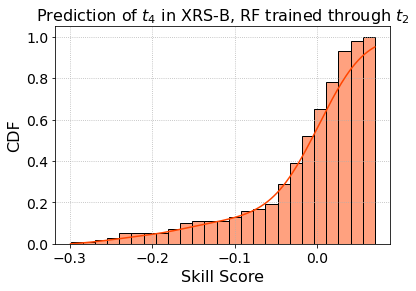

In [47]:
# Plot the CDF in XRS-B

sns.histplot(ss18, stat="probability", bins=25, cumulative=True, kde=True, color='orangered')
plt.title(r'Prediction of $t_{4}$ in XRS-B, RF trained through $t_{2}$')
plt.ylabel(r'CDF', fontsize=16)
plt.xlabel(r'Skill Score', fontsize=16)
plt.grid(True, which='major', axis='both')

plt.savefig('t2b_cdf.png', dpi=300, bbox_inches='tight',)

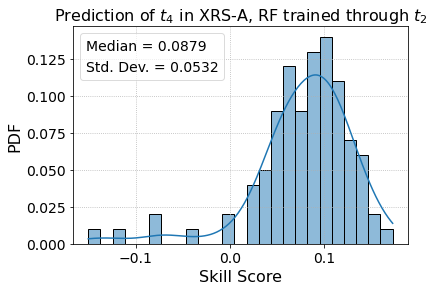

In [48]:
# Plot the PDF in XRS-A

sns.histplot(ss054, stat="probability", bins=25, kde=True)
## Add textbox with median and standard deviation:
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 2
labels = []
labels.append("Median = {0:.4f}".format(np.median(ss054)))
labels.append("Std. Dev. = {0:.4f}".format(np.std(ss054)))
plt.legend(handles, labels, loc='best', fontsize=14, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
plt.ylabel(r'PDF', fontsize=16)
plt.xlabel(r'Skill Score', fontsize=16)
plt.title(r'Prediction of $t_{4}$ in XRS-A, RF trained through $t_{2}$')
plt.grid(True, which='major', axis='both')

plt.savefig('t2a_pdf.png', dpi=300, bbox_inches='tight',)

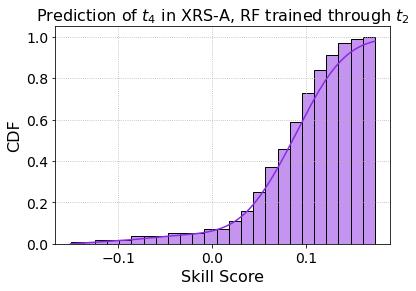

In [49]:
# Plot the CDF in XRS-A

sns.histplot(ss054, stat="probability", bins=25, cumulative=True, kde=True, color='blueviolet')
plt.title(r'Prediction of $t_{4}$ in XRS-A, RF trained through $t_{2}$')
plt.ylabel(r'CDF', fontsize=16)
plt.xlabel(r'Skill Score', fontsize=16)
plt.grid(True, which='major', axis='both')

plt.savefig('t2a_cdf.png', dpi=300, bbox_inches='tight',)

Now, we repeat the Monte Carlo simulation one more time, training the data set through time $t_{3}$.  

In [50]:
ind = np.arange(len(data['start_time']))  # This is for selecting out other entries corresponding to the train/test split.

var_names4 = (
    [f'f{i}_b' for i in range(4)] + [f'f{i}_a' for i in range(4)] + [f'f{i}_b' for i in range(5,9)] +
    [f'f{i}_a' for i in range(5,9)] + [f't_{i}' for i in range(4)] + [f't_{i}' for i in range(5,9)] +
    [f'a{i}_b' for i in range(4)] + [f'a{i}_a' for i in range(4)] + [f'a{i}_b' for i in range(5,9)] +
    [f'a{i}_a' for i in range(5,9)] + [f'dfdt{i}_b' for i in range(4)] + [f'dfdt{i}_a' for i in range(4)] + 
    [f'dfdt{i}_b' for i in range(5,9)] + [f'dfdt{i}_a' for i in range(5,9)]
)

features4 = np.array([data[v] for v in var_names4]).T
labels4 = np.array([data['t_4'], data['t_9']]).T

t2_mod = data['t_2'] - data['t_0']
t4_mod = data['t_4'] - data['t_0']
t7_mod = data['t_7'] - data['t_5']
t9_mod = data['t_9'] - data['t_5']

ss18 = []
ss054 = []
rf = RandomForestRegressor(**rf_options)
for i in range(100):
    train_features, test_features, train_labels, test_labels, train_ind, test_ind = train_test_split(
    features4, labels4, ind, test_size = 0.33, random_state = None)
    rf.fit(train_features, train_labels)
    predictions = rf.predict(test_features)
    
    estimator.fit(np.log10(t2_mod[train_ind[:]].reshape(-1,1)),np.log10(t4_mod[train_ind[:]].reshape(-1,1)))
    slope18 = estimator.coef_[0]
    int18 = estimator.intercept_
    estimator.fit(np.log10(t7_mod[train_ind[:]].reshape(-1,1)),np.log10(t9_mod[train_ind[:]].reshape(-1,1)))
    slope054 = estimator.coef_[0]
    int054 = estimator.intercept_
    
    mse18 = np.mean((test_labels[:,0]-predictions[:,0])**2.)
    ref_t4 = 10.0**(int18) * (t2_mod[test_ind[:]])**(slope18) + data['t_0'][test_ind[:]]
    ref18 = np.mean((data['t_4'][test_ind[:]]-ref_t4[:])**2.)
    ss18.append(1.0 - mse18/ref18)
    
    mse054 = np.mean((test_labels[:,1]-predictions[:,1])**2.)
    ref_t9 = 10.0**(int054) * (t7_mod[test_ind[:]])**(slope054) + data['t_5'][test_ind[:]]
    ref054 = np.mean((data['t_9'][test_ind[:]]-ref_t9[:])**2.)
    ss054.append(1 - mse054/ref054)


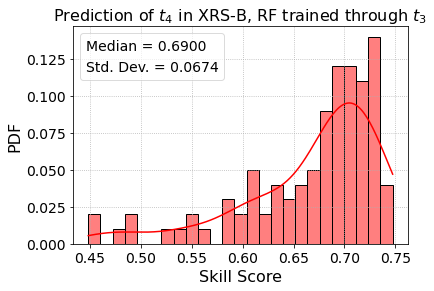

In [51]:
# Plot the PDF in XRS-B

sns.histplot(ss18, stat="probability", bins=25, kde=True, color='Red')
## Add textbox with median and standard deviation:
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 2
labels = []
labels.append("Median = {0:.4f}".format(np.median(ss18)))
labels.append("Std. Dev. = {0:.4f}".format(np.std(ss18)))
plt.legend(handles, labels, loc='best', fontsize=14, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
plt.ylabel(r'PDF', fontsize=16)
plt.xlabel(r'Skill Score', fontsize=16)
plt.title(r'Prediction of $t_{4}$ in XRS-B, RF trained through $t_{3}$')
plt.grid(True, which='major', axis='both')

plt.savefig('t3b_pdf.png', dpi=300, bbox_inches='tight',)

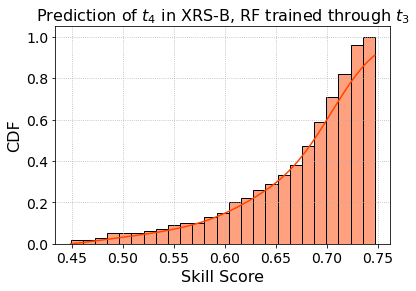

In [52]:
# Plot the CDF in XRS-B

sns.histplot(ss18, stat="probability", bins=25, cumulative=True, kde=True, color='orangered')
plt.title(r'Prediction of $t_{4}$ in XRS-B, RF trained through $t_{3}$')
plt.ylabel(r'CDF', fontsize=16)
plt.xlabel(r'Skill Score', fontsize=16)
plt.grid(True, which='major', axis='both')

plt.savefig('t3b_cdf.png', dpi=300, bbox_inches='tight',)

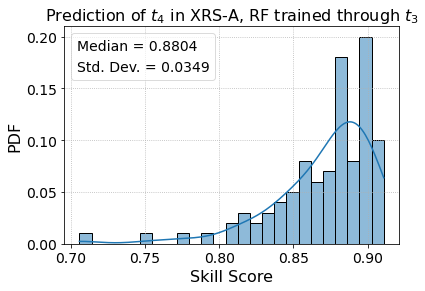

In [53]:
# Plot the PDF in XRS-A

sns.histplot(ss054, stat="probability", bins=25, kde=True)
## Add textbox with median and standard deviation:
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 2
labels = []
labels.append("Median = {0:.4f}".format(np.median(ss054)))
labels.append("Std. Dev. = {0:.4f}".format(np.std(ss054)))
plt.legend(handles, labels, loc='best', fontsize=14, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
plt.ylabel(r'PDF', fontsize=16)
plt.xlabel(r'Skill Score', fontsize=16)
plt.title(r'Prediction of $t_{4}$ in XRS-A, RF trained through $t_{3}$')
plt.grid(True, which='major', axis='both')

plt.savefig('t3a_pdf.png', dpi=300, bbox_inches='tight',)

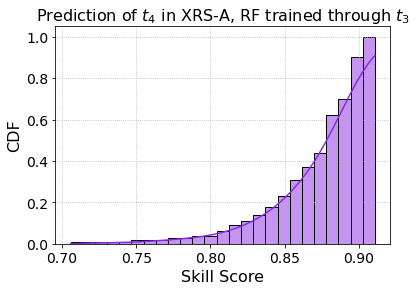

In [54]:
# Plot the CDF in XRS-A

sns.histplot(ss054, stat="probability", bins=25, cumulative=True, kde=True, color='blueviolet')
plt.title(r'Prediction of $t_{4}$ in XRS-A, RF trained through $t_{3}$')
plt.ylabel(r'CDF', fontsize=16)
plt.xlabel(r'Skill Score', fontsize=16)
plt.grid(True, which='major', axis='both')

plt.savefig('t3a_cdf.png', dpi=300, bbox_inches='tight',)

## Supplementary Material

Finally, as a supplement to the text, we make predictions of $t_{2}$ to see how capable such an early prediction is.  We repeat the analysis above, this time training the RF only through time $t_{1}$.

In [55]:
ind = np.arange(len(data['start_time']))  # This is for selecting out other entries corresponding to the train/test split.
var_names2 = (
    [f'f{i}_b' for i in range(2)] + [f'f{i}_a' for i in range(2)] + [f'f{i}_b' for i in range(5,7)] +
    [f'f{i}_a' for i in range(5,7)] + [f't_{i}' for i in range(2)] + [f't_{i}' for i in range(5,7)] +
    [f'a{i}_b' for i in range(2)] + [f'a{i}_a' for i in range(2)] + [f'a{i}_b' for i in range(5,7)] +
    [f'a{i}_a' for i in range(5,7)] + [f'dfdt{i}_b' for i in range(2)] + [f'dfdt{i}_a' for i in range(2)] + 
    [f'dfdt{i}_b' for i in range(5,7)] + [f'dfdt{i}_a' for i in range(5,7)]
)

features2 = np.array([data[v] for v in var_names2]).T
labels2 = np.array([data['t_2'], data['t_3'], data['t_4'], data['t_7'], data['t_8'], data['t_9']]).T

In [56]:
# change random_state = None for truly random splits.
train_features2, test_features2, train_labels2, test_labels2, train_ind2, test_ind2 = train_test_split(
    features2, labels2, ind, test_size = 0.33, random_state = 25)

In [57]:
rf = RandomForestRegressor(**rf_options)

In [58]:
rf.fit(train_features2, train_labels2)

RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=1500,
                      n_jobs=-1)

In [59]:
predictions2 = rf.predict(test_features2)

In [60]:
test_error2 = 1 - rf.score(test_features2, test_labels2)

In [61]:
print(test_error2)

0.3983737801733065


In [62]:
estimator = TheilSenRegressor(random_state=10, n_jobs=-1, max_subpopulation=3e4)

Now, we plot each of the predicted timings.

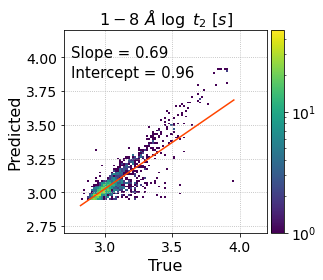

In [63]:
# Fit a line to the data
x_plot = np.linspace(np.log10(test_labels2[:,0].min()), np.log10(test_labels2[:,0].max()))
estimator.fit(np.log10(test_labels2[:,[0]]), np.log10(predictions2[:,[0]]))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

# Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels2[:,0]), np.log10(predictions2[:,0]), bins=75, norm=LogNorm())

plt.plot(x_plot, y_plot, color='orangered')
plt.text(2.75, 4.0, 'Slope = %.2f' %(slope18), fontsize=15)
plt.text(2.75, 3.85, 'Intercept = %.2f' %(int18), fontsize=15)
plt.xlabel(r'True', fontsize=16)
plt.ylabel(r'Predicted', fontsize=16)
plt.title(r'$1-8\ \AA\ \log\ t_{2}\ [s]$')
plt.xlim(2.7, 4.2)
plt.ylim(2.7, 4.2)
plt.tight_layout()
plt.grid(True, which='major', axis='both')

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)


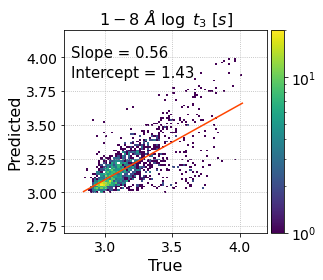

In [64]:
# Fit a line to the data
x_plot = np.linspace(np.log10(test_labels2[:,1].min()), np.log10(test_labels2[:,1].max()))
estimator.fit(np.log10(test_labels2[:,[1]]), np.log10(predictions2[:,[1]]))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

# Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels2[:,1]), np.log10(predictions2[:,1]), bins=75, norm=LogNorm())

plt.plot(x_plot, y_plot, color='orangered')
plt.text(2.75, 4.0, 'Slope = %.2f' %(slope18), fontsize=15)
plt.text(2.75, 3.85, 'Intercept = %.2f' %(int18), fontsize=15)
plt.xlabel(r'True', fontsize=16)
plt.ylabel(r'Predicted', fontsize=16)
plt.title(r'$1-8\ \AA\ \log\ t_{3}\ [s]$')
plt.xlim(2.7, 4.2)
plt.ylim(2.7, 4.2)
plt.tight_layout()
plt.grid(True, which='major', axis='both')

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)


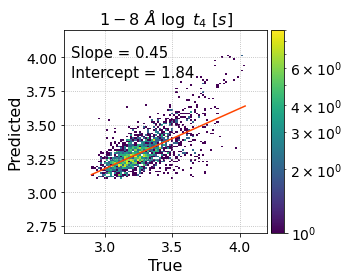

In [65]:
# Fit a line to the data
x_plot = np.linspace(np.log10(test_labels2[:,2].min()), np.log10(test_labels2[:,2].max()))
estimator.fit(np.log10(test_labels2[:,[2]]), np.log10(predictions2[:,[2]]))
slope18 = estimator.coef_[0]
int18 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

# Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels2[:,2]), np.log10(predictions2[:,2]), bins=75, norm=LogNorm())

plt.plot(x_plot, y_plot, color='orangered')
plt.text(2.75, 4.0, 'Slope = %.2f' %(slope18), fontsize=15)
plt.text(2.75, 3.85, 'Intercept = %.2f' %(int18), fontsize=15)
plt.xlabel(r'True', fontsize=16)
plt.ylabel(r'Predicted', fontsize=16)
plt.title(r'$1-8\ \AA\ \log\ t_{4}\ [s]$')
plt.xlim(2.7, 4.2)
plt.ylim(2.7, 4.2)
plt.tight_layout()
plt.grid(True, which='major', axis='both')

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)



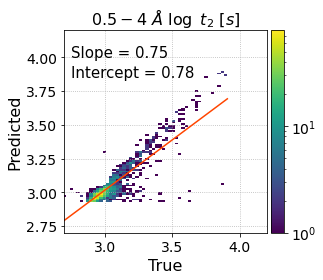

In [66]:
# Fit a line to the data
x_plot = np.linspace(np.log10(test_labels2[:,3].min()), np.log10(test_labels2[:,3].max()))
estimator.fit(np.log10(test_labels2[:,[3]]), np.log10(predictions2[:,[3]]))
slope054 = estimator.coef_[0]
int054 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

# Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels2[:,3]), np.log10(predictions2[:,3]), bins=75, norm=LogNorm())

plt.plot(x_plot, y_plot, color='orangered')
plt.text(2.75, 4.0, 'Slope = %.2f' %(slope054), fontsize=15)
plt.text(2.75, 3.85, 'Intercept = %.2f' %(int054), fontsize=15)
plt.xlabel(r'True', fontsize=16)
plt.ylabel(r'Predicted', fontsize=16)
plt.title(r'$0.5-4\ \AA\ \log\ t_{2}\ [s]$')
plt.xlim(2.7, 4.2)
plt.ylim(2.7, 4.2)
plt.tight_layout()
plt.grid(True, which='major', axis='both')

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)



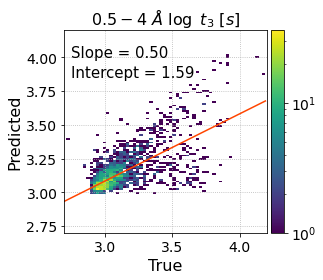

In [67]:
# Fit a line to the data
x_plot = np.linspace(np.log10(test_labels2[:,4].min()), np.log10(test_labels2[:,4].max()))
estimator.fit(np.log10(test_labels2[:,[4]]), np.log10(predictions2[:,[4]]))
slope054 = estimator.coef_[0]
int054 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

# Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels2[:,4]), np.log10(predictions2[:,4]), bins=75, norm=LogNorm())

plt.plot(x_plot, y_plot, color='orangered')
plt.text(2.75, 4.0, 'Slope = %.2f' %(slope054), fontsize=15)
plt.text(2.75, 3.85, 'Intercept = %.2f' %(int054), fontsize=15)
plt.xlabel(r'True', fontsize=16)
plt.ylabel(r'Predicted', fontsize=16)
plt.title(r'$0.5-4\ \AA\ \log\ t_{3}\ [s]$')
plt.xlim(2.7, 4.2)
plt.ylim(2.7, 4.2)
plt.tight_layout()
plt.grid(True, which='major', axis='both')

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)


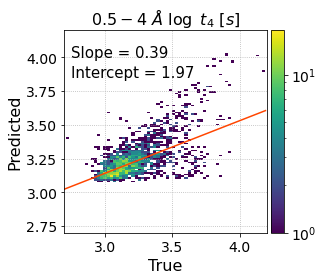

In [68]:
# Fit a line to the data
x_plot = np.linspace(np.log10(test_labels2[:,5].min()), np.log10(test_labels2[:,5].max()))
estimator.fit(np.log10(test_labels2[:,[5]]), np.log10(predictions2[:,[5]]))
slope054 = estimator.coef_[0]
int054 = estimator.intercept_
y_plot = estimator.coef_ * x_plot + estimator.intercept_

# Plot the data
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

plt.hist2d(np.log10(test_labels2[:,5]), np.log10(predictions2[:,5]), bins=75, norm=LogNorm())

plt.plot(x_plot, y_plot, color='orangered')
plt.text(2.75, 4.0, 'Slope = %.2f' %(slope054), fontsize=15)
plt.text(2.75, 3.85, 'Intercept = %.2f' %(int054), fontsize=15)
plt.xlabel(r'True', fontsize=16)
plt.ylabel(r'Predicted', fontsize=16)
plt.title(r'$0.5-4\ \AA\ \log\ t_{4}\ [s]$')
plt.xlim(2.7, 4.2)
plt.ylim(2.7, 4.2)
plt.tight_layout()
plt.grid(True, which='major', axis='both')

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)


# Observed relationship between fluence and duration
How does the observed fluence compare with the approximate duration $t_{4}$?  We plot it in each channel below.

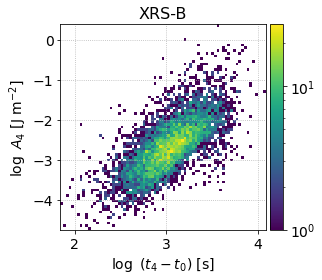

In [69]:
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

t4_mod = data['t_4'] - data['t_0']

plt.hist2d(np.log10(t4_mod), np.log10(data['a4_b']), bins=75, norm=LogNorm())
plt.tight_layout()
plt.title('XRS-B',)
plt.xlabel(r'$\log\ (t_{4} - t_{0})$ [s]')
plt.ylabel(r'$\log\ A_{4}$ [J m$^{-2}$]')
plt.grid(True,which='major',axis='both',linestyle=':')
plt.tight_layout()

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)

plt.savefig('t4_vs_A4_18.png', dpi=300, bbox_inches='tight',)

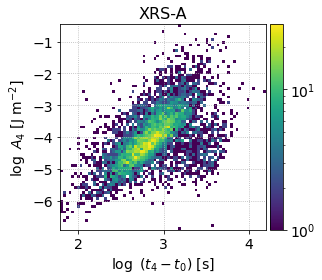

In [70]:
fig, ax = plt.subplots()
ax.set_box_aspect(1)  # set one-to-one aspect ratio

t9_mod = data['t_9'] - data['t_5']

plt.hist2d(np.log10(t9_mod), np.log10(data['a9_a']), bins=75, norm=LogNorm())
plt.tight_layout()
plt.title('XRS-A',)
plt.xlabel(r'$\log\ (t_{4} - t_{0})$ [s]')
plt.ylabel(r'$\log\ A_{4}$ [J m$^{-2}$]')
plt.grid(True,which='major',axis='both',linestyle=':')
plt.tight_layout()

cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 
                    0.03, ax.get_position().height])
plt.colorbar(cax=cax)

plt.savefig('t4_vs_A4_054.png', dpi=300, bbox_inches='tight',)